<a href="https://colab.research.google.com/github/qazwsx351789/QSVM/blob/master/QSVM_NonMarkovian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
!pip install qutip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 27.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import cmath
# Scikit Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error as mse

from qutip import expect , Qobj
import qutip
import pandas as pd
import math

In [3]:
import qutip
from qutip import Qobj,basis
from qutip import sigmax , sigmaz , sigmay
import qutip
import math
# from qutip.metrics import fidelity
import math
import numpy as np
import matplotlib.pyplot as plt
from qutip import tensor

Connect to your goole drive.

# Train SVM

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## SVM func

In [5]:
def shift(target):
  _min = np.min(target)
  return [t-_min for t in target]
def _filter(target , filter) :
  r = []
  rid = []
  rest = []
  for idx , t in enumerate(target) :
    if t > filter :
      r.append(t)
      rid.append(idx)
    else :
      rest.append(t)
  return r ,rid , rest
def indexing(target , index) :
  return [target[idx] for idx in index]
def _plot(x,y , filter,color = [] , name = ""):
  px = []
  py = []
  for _x , _y in zip(x,y) :
    if abs(_y) < filter :
      px.append(_x)
      py.append(_y)
  if color == [] :
    plt.scatter( px, py)
  else :
    plt.scatter(px ,py , c =color)
  plt.plot(np.linspace(0,0.1) , np.linspace(0,0.1))
  if name != "" :
    plt.savefig(name)
  plt.show()
def _plot_p(x,y , filter,color = [] , name = ""):
  px = []
  py = []
  for _x , _y in zip(x,y) :
    if abs(_y) < filter :
      px.append(_x)
      py.append(abs(_y))
  if color == [] :
    plt.scatter( px, py)
  else :
    plt.scatter(px ,py , c =color)
  plt.plot(np.linspace(0,0.1) , np.linspace(0,0.1))
  if name != "" :
    plt.savefig(name)
  plt.show()

In [6]:
def tune(target ,x_train , y_train,kernel_method) :
  param_grid =[{'kernel':kernel_method,
      'epsilon':np.arange(0,1,0.001),
             'C':np.arange(0.1,1,0.1)}]
  # 初始化网格搜索的方法
  rd_search = RandomizedSearchCV(target ,param_grid,n_jobs=8)
  rd_search.fit(x_train, y_train)
  return rd_search.best_params_
def _tune(target ,x_train,y_train,x_test , y_test ,kernel_method , tg = 'ts'):
  param_grid =[{'kernel':kernel_method,
    'epsilon':np.arange(0,0.1,0.001),
            'C':np.arange(0.1,1,0.1)}]
  best = 9999
  best_dict = {'kernel': kernel_method[0]}
  for ep in (param_grid[0]['epsilon']):
    for c in param_grid[0]['C']:
      _svr = SVR(kernel = kernel_method[0] , epsilon = ep , C=c)
      _svr.fit(x_train , y_train)
      if tg == 'ts':
        _rs = _svr.predict(x_test)
        _sc = mse(_rs , y_test)
      else :
        _rs = _svr.predict(x_train)
        _sc = mse(_rs , y_train)
      if _sc < best :
        best = _sc
        best_dict['epsilon'] = ep
        best_dict['C'] = c
  print(param_grid[0]['C'])
  return best_dict

## Dataset

In [7]:
#file_path = '/content/drive/MyDrive/ASVM/output06_24.csv'
# file path
file_path = '/content/drive/MyDrive/QSVM/output08_21_BSBM.csv'
data = pd.read_csv(file_path,header=None)
x=data.iloc[:,0:20]
x= [x.iloc[idx , :] for idx in range(len(x))]
y=data.iloc[:,20]
mxy = np.max(y)
y,idx , rest = _filter(y,-1)
#y = shift(y)
x = indexing(x,idx)
len(x) , len(y)

(120000, 120000)

In [8]:
len(x) , len(y)

(120000, 120000)

In [9]:
x, _, y, _ = train_test_split(x, y, test_size=0.4,random_state = 777)

In [10]:
x ,y = x[:] , y[:]

## Train Data

In [11]:

#x_train_lst, x_test_lst, y_train, y_test = train_test_split(x, y, test_size=0.4,random_state = 0)
start =0
train_size = 1000
test_size = int(train_size * 1.3) + start
train_size = train_size + start
x_train_lst, x_test_lst = x[start :train_size] , x[train_size:test_size]
y_train, y_test =  y[start:train_size] , y[train_size : test_size]
print(len(x_train_lst) ,len(y_train) , len(x_train_lst[0]) , len(x_test_lst))

1000 1000 20 300


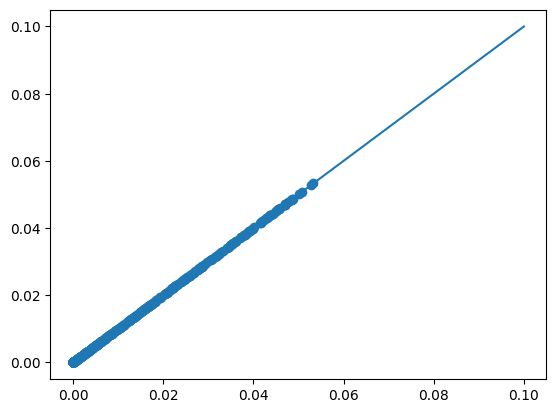

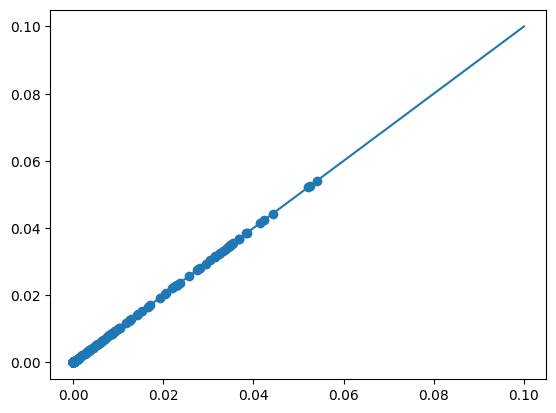

(None, None)

In [12]:

_plot(y_train,y_train,99) , _plot(y_test,y_test,99)

## PCA

### approach1


In [13]:
from numpy import linalg as LA
from sklearn.preprocessing import StandardScaler
#step1
scaler = StandardScaler()
train = scaler.fit_transform(x_train_lst)
test = scaler.fit_transform(x_test_lst)

#step2
cov_train = np.cov(train.T)

#step3
eig_vals, eig_vecs = LA.eig(cov_train)

#step4
sort_indices = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[sort_indices]
eig_vecs = eig_vecs[:, sort_indices]

#step5
k = 10 ## The number of features after PCA
eig_vec = eig_vecs[:, :k]


#step6
x_train_lst = np.real(np.dot(train, eig_vec))
x_test_lst = np.real(np.dot(test, eig_vec))


In [14]:
x_train_lst[20]

array([-2.25061154e+00,  1.41020438e+00,  1.14405788e-01, -2.58414128e-01,
       -6.23768779e-02,  7.35853584e-02,  3.62190882e-03, -8.72276869e-03,
        9.42466795e-04, -6.78798223e-05])

In [15]:
imax=0
imin=0
for ll in x_train_lst:
  imax=max(imax,max(ll))
  imin=min(imin,min(ll))
print("imax=",imax)
print("imin=",imin)

imax= 11.412538872570742
imin= -11.451331827187198


In [16]:
# train_pca_q=x_train_lst
# test_pca_q=x_test_lst

In [17]:
# Normalize
Norm=math.pi*2
train_pca_q=[]
test_pca_q=[]
for i,ll in enumerate(x_train_lst):
  train_pca_q.append(x_train_lst[i]/max(imax,abs(imin))*Norm)

for i,ll in enumerate(x_test_lst):
  test_pca_q.append(x_test_lst[i]/max(imax,abs(imin))*Norm)

### approach 2

In [18]:
# pca_on = True
# PCA_n = 10
# if pca_on :
#   color = np.array([1,1,0,1])
#   pca = PCA(n_components=PCA_n)
#   pca.fit(train)
#   train_pca = pca.transform(train)
#   test_pca = pca.transform(test)
#   print(train_pca.shape , test_pca.shape)

# Qmapping

In [126]:
sigx = sigmax()
sigz = sigmaz()
sigy = sigmay()
iid = qutip.qeye(2)
rr = Qobj([[0,0],[0,1]])
ee = Qobj([[1,0],[0,0]])
def gst(d):
  b = [basis(2,0) for i in range(d)]
  return tensor(b)
def form_op(tg,operator , d) :
    r = iid
    if 0 in tg :
        r = operator
    for i in range(1,d):
        if i in tg :
            r = tensor(r , operator)
        else :
            r = tensor(r , iid)
    return r
def dynamics(d):
  h = form_op([0] , sigx , d)
  for i in range(1,d) :
    h += form_op([i],sigx ,d)
  return h

def EncodingP(d,data,op):
  if op=="z":
    h = form_op([0] , ee * cmath.exp(-1j*data[0]) + rr * cmath.exp(1j*data[0]) , 1)
    for i in range(1,d) :
      h = tensor(h,form_op([0], ee * cmath.exp(-1j*data[i]) + rr * cmath.exp(1j*data[i]) ,1))
    return h
  elif op=="x":
    h = form_op([0] , iid * math.cos(data[0]) - sigx * 1j*math.sin(data[0]) , 1)
    for i in range(1,d) :
      h = tensor(h,form_op([0] , iid * math.cos(data[i]) - sigx *1j* math.sin(data[i]) , 1))
    return h

def Entangle(config , d):
  for idx ,x in enumerate(config) :
    for idy ,y in enumerate(x) :
      try :
        h += y/2 * form_op([idx , idy] , rr ,d)
      except :
        h  = y/2 * form_op([idx , idy] , rr ,d)
  return h
def HMap(config , d, Ruby) :
  return Ruby*dynamics(d) + Entangle(config , d)

In [127]:
dim = 10
left_gst = gst(dim).dag()
right_gst = gst(dim)

In [128]:
# def HMap(config ,d ,Ruby) :
#   CH = Constant_H(config , d, Ruby)
#   return CH
def evolution(H,t) :
  return (-1j * H * t).expm()
def k_value(left , right) :
  k = (left.dag() * right)
  return (k * k.conjugate()).real

In [129]:
def Qmap(config , d,t,Data ,Ruby,op, tier):
  rs = []
  h = HMap(config ,d ,Ruby)
  right_gst = gst(d)
  ev=evolution(h,t)
  if tier ==0:
    for da in Data:
      EP=EncodingP(d,da,op)
      state= ev * right_gst
      state= EP * state
      rs.append(state)
  elif tier ==1:
    for da in Data:
      EP=EncodingP(d,da,op)
      state= EP * right_gst
      state= ev * state
      state= EP * state
      rs.append(state)
  elif tier ==2:
    for da in Data:
      EP=EncodingP(d,da,op)
      state= EP * right_gst
      state= ev * state
      state= EP * state
      state= ev * state
      state= EP * state
      rs.append(state)
  return rs
def get_q_kernel(state1 , state2 , status = "train" ):
  k_matrix = []
  for i ,s in enumerate(state1) :
    _k = []
    for j  , st in enumerate(state2) :
      if i >= j or status == "test":
        _k.append(k_value(s,st))
      else :
        _k.append(0)
    k_matrix.append(_k)
  if status == "train" :
    for idy , km in enumerate(k_matrix) :
      for idx , k in enumerate(km) :
          if k == 0 :
              k_matrix[idy][idx] = k_matrix[idx][idy]
  return np.array(k_matrix)

In [130]:
# kernel transformation, visualization
def diagnal(target , diag):
  for k in range(0,len(target)) :
    target[k][k] = diag
  return target
def rescale(target):
  _min = np.min(target)
  _max = np.max(target)
  delta  = _max - _min
  for i in range(0,len(target)) :
    for j in range(0,len(target[0])) :
      target[i][j] = (target[i][j] - _min) / delta
  return target
def show_kmatrix(test=[], train = [],name = ""):
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))
  # if test != [] :
  a1=axs[0].imshow(np.asmatrix(test),
                interpolation='nearest', origin='upper', cmap='Blues')
  plt.colorbar(a1)
  axs[0].set_title("testing kernel matrix")
  # if train != [] :
  a2=axs[1].imshow(np.asmatrix(train),
                interpolation='nearest', origin='upper', cmap='Blues')
  plt.colorbar(a2)
  axs[1].set_title("training kernel matrix")
  if name == "" :
    plt.show()
  else :
    plt.savefig(name)

#Kernal Function

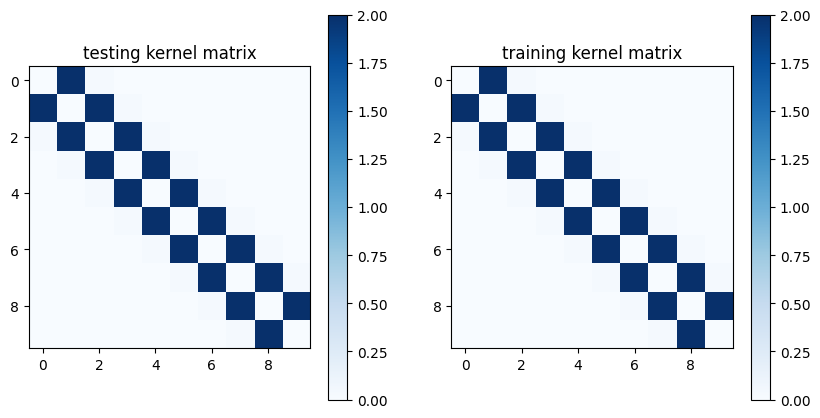

In [131]:
dim = dim
left_gst = gst(dim).dag()
right_gst = gst(dim)
Roby=1
t = np.pi
V=2
config = np.ones([dim ,dim])*V
for idx , cf in enumerate(config) :
  for idy , c in enumerate(cf) :
    if idx == idy:
      config[idx][idy] = 0
    else:
      config[idx][idy]=V*abs(idx-idy)**-6
show_kmatrix(train = config , test = config,name = "")

In [132]:
op ="z"
tier=2

qx_train_lst = Qmap(config , dim ,t ,train_pca_q, Roby,op,tier)
qx_test_lst = Qmap(config , dim ,t ,test_pca_q, Roby,op,tier)

In [133]:
target_kernel = get_q_kernel(qx_train_lst,qx_train_lst)

In [134]:
test_kernel = get_q_kernel(qx_test_lst,qx_train_lst , status = "test")

In [135]:
target_kernel[0][0],target_kernel[1][1]

(0.9999999999999982, 0.9999999999999989)

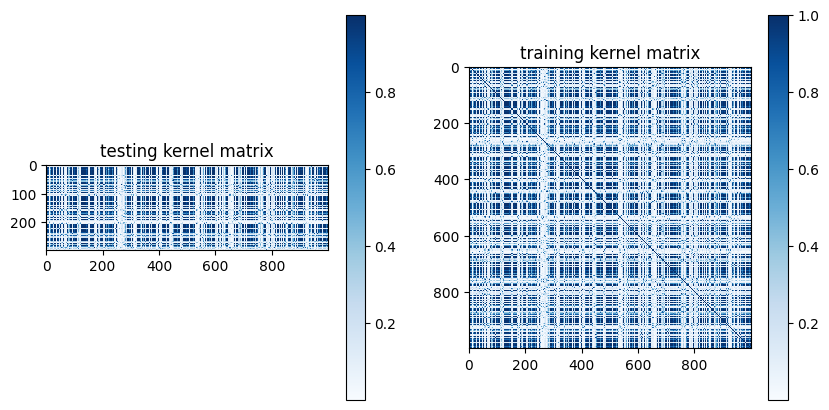

In [136]:
show_kmatrix(train = target_kernel , test = test_kernel,name = "qkernel")

# SVM

### Matrix Transform

In [31]:
trans_on = False
rbf_on = False
rescale_on = False

In [32]:
qn = 1
def get_nq_obj(target , n):
    return qutip.tensor([target for i in range(n)])
def get_state(g):
    e = 1-g
    state = Qobj([[g*g , g*e],[e*g,e*e]])
    return get_nq_obj(state , qn)
mop = Qobj([[1,0] , [0,-1]])
sigz = get_nq_obj( mop, qn)
def _expect_trans(g):
  return expect(sigz , get_state(g**(1/11))).real
def expect_trans(target):
  _t = []
  for idx , g in enumerate(target.flatten()) :
    _t.append(_expect_trans(g))
  _t = np.array(_t)
  return _t.reshape(target.shape)

In [33]:
if trans_on :
  k_trans = expect_trans(np.array(target_kernel))
  kt_trans = expect_trans(test_kernel)
  show_kmatrix(test = kt_trans , train = k_trans)
  target_kernel = k_trans
  test_kernel = kt_trans

### Train

In [153]:
svr = SVR()
argv = _tune(svr,np.array(target_kernel) , y_train ,np.array(test_kernel) , y_test, ['precomputed'] , tg = 'tr' )
argv


[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


{'kernel': 'precomputed', 'epsilon': 0.001, 'C': 0.9}

In [152]:
svr = SVR(kernel = argv['kernel'] , epsilon = argv['epsilon'] , C = argv['C'])
#svr = SVR(kernel = 'precomputed' , epsilon = 0)
svr.fit(target_kernel, y_train)

SVR(C=0.1, epsilon=0.293)

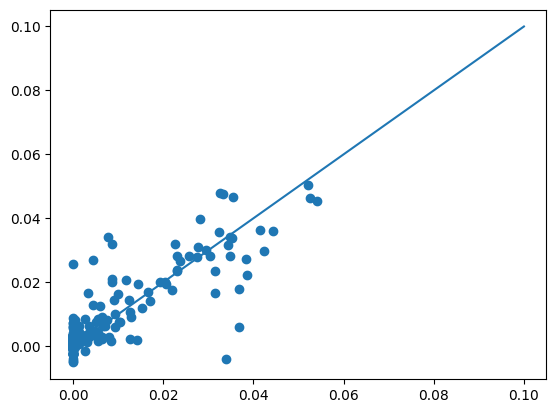

In [139]:
rs_t = svr.predict(test_kernel)
_plot(y_test , rs_t , 99 , name = 'qtest')

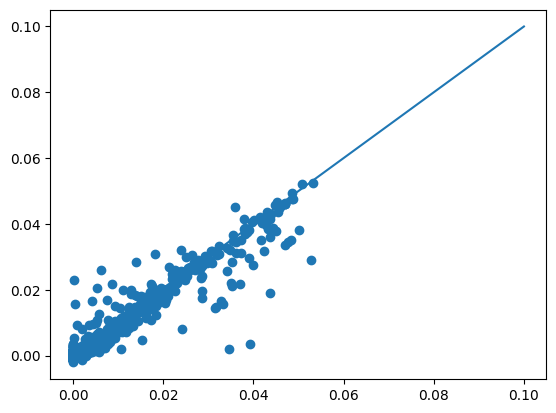

In [140]:

rs = svr.predict(target_kernel)
_plot(y_train , rs ,99 , name = 'qtrain')


## Classical

In [141]:

import sklearn
_k = sklearn.metrics.pairwise.rbf_kernel(x_train_lst,x_train_lst)
_kk = sklearn.metrics.pairwise.rbf_kernel(x_test_lst,x_train_lst)

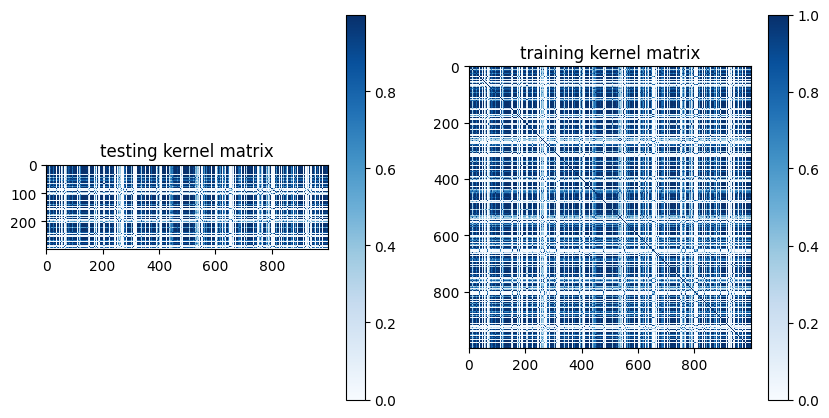

In [142]:
show_kmatrix(test = _kk , train = _k , name = 'ckernel')

In [143]:
mth = 'rbf'

In [144]:
_svr = SVR()
argv = tune(_svr,x_train_lst , y_train , [mth])
argv

{'kernel': 'rbf', 'epsilon': 0.293, 'C': 0.1}

In [145]:
#_svr = SVR(kernel = argv['kernel'] , epsilon = argv['epsilon'] , C = argv['C'])
_svr = SVR(kernel = mth , epsilon = 0, C=0.4)
_svr.fit(x_train_lst, y_train)

SVR(C=0.4, epsilon=0)

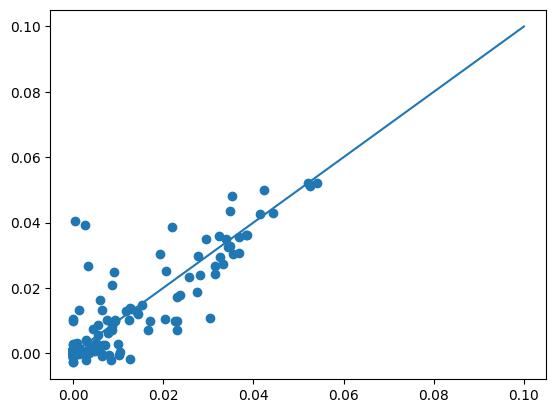

In [146]:
_rs_t = _svr.predict(x_test_lst)
_plot(y_test , _rs_t , 999 , name = 'ctest')

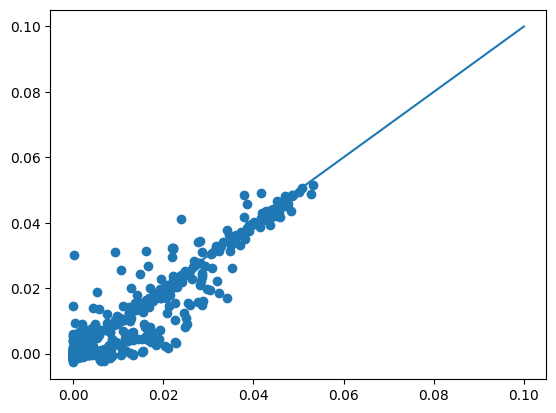

In [147]:
_rs = _svr.predict(x_train_lst)
_plot(y_train , _rs , 999 , name = 'ctrain')

# Result

In [154]:
print(f'Classical {mth} testing mse : {mse(_rs_t , y_test)}')
print(f'Quantum testing mse : {mse(rs_t,y_test)}')

Classical rbf testing mse : 2.6362826813054036e-05
Quantum testing mse : 3.3706412864894107e-05


In [155]:
print(f'Classical {mth} training mse : {mse(_rs , y_train)}')
print(f'Quantum training mse : {mse(rs,y_train)}')

Classical rbf training mse : 1.5050098952150842e-05
Quantum training mse : 1.231303544186164e-05
